# Collaborative Filtering

In Collaborative Filtering, the similarity between users is used to recommend books to a user. The previous history of ratings of all the users is collected. The nearest neighbor user-based approach is used in building the recommendation system. The similarity measures Mean Squared Difference (MSD) and Pearson correlation coefficient are compared for the algorithm. The MSD appeared to give a better value of RMSE with KNNMeans algorithm in the surprise package 

In [36]:
import numpy as np
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import SVD
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
import operator

In [2]:
books = pd.read_csv('data/books.csv')
ratings = pd.read_csv('data/ratings.csv')

To find out the rating scale used in the dataset

In [7]:
ratings['rating'].min()

1

In [8]:
ratings['rating'].max()

5

Load the dataset into a 'surprise' dataset using Reader form the package by mentioning the scale of rating

Reference: https://surprise.readthedocs.io/en/stable/getting_started.html#use-a-custom-dataset

In [3]:
reader = Reader(rating_scale=(1, 5))

rat = Dataset.load_from_df(ratings[['book_id', 'user_id', 'rating']], reader)

Entire data is used as trainset to build the recommendation system

In [11]:
trainset = rat.build_full_trainset()

Parameters selection using GridsearchCV similar to Sci-Kit Learn

In [5]:
params = {
    "name": ["pearson","msd"]
}

grid = {"sim_options": params}

Test the data using KNNWithMeans Algorithm to find out the optimum parameters for the algotithm using GridSearchCV

In [6]:
algorithm1 = GridSearchCV(KNNWithMeans, grid, measures=["rmse", "mae"])
predictions1 = algorithm1.fit(rat)
print(algorithm1.best_score["rmse"])
print(algorithm1.best_params["rmse"])

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
0.8579154698571572
{'sim_options': {'name': 'msd', 'user_based': True}}


Therefore, it is observed that MSD (Mean Squared Distance) similarity gives a better RMSE. User-based MSD similarity is selected to build the recommnedation system.

In [7]:
#User-based msd similarity
sim_options = {
    "name": "msd",
    "user_based": True
}
userbasedalgo = KNNWithMeans(sim_options=sim_options)

In [12]:
userbasedalgo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


To test the algorithm for a random user and a book

In [25]:
prediction = userbasedalgo.predict(11082, 41200)
prediction.est

3.8565335989797873

'predict' is a function which takes user_id as the input, calculates the estimates of ratings the user would give to each book and recommends top 5 books to the user. The books to be recommended are checked if the user has previously rated that book. Those books which are already rated are excluded from suggestions to avoid repetition.
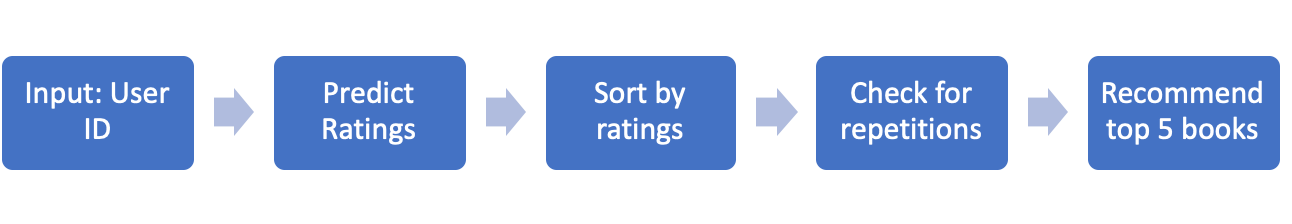

In [11]:
def predict(userid):
    a = 10000
    est_list = list([] for _ in range(a))
    r = ratings.loc[ratings['user_id'] == userid]
    for i in range(1,10001):
        p = userbasedalgo.predict(i, userid)
        est_list[i-1].append(i)
        est_list[i-1].append(p.est)
    est_list_sorted = sorted(est_list, key=lambda x: x[1], reverse=True)
    list_books_recom = list()
    for i in est_list_sorted:
        if i[0] not in list(r['book_id']):
            list_books_recom = list_books_recom + [i[0]]
    list_books_recom = list_books_recom[0:5]
    index_list_books_recom = [x - 1 for x in list_books_recom] #To correct to the index of each book in books.csv
    return books['title'].iloc[index_list_books_recom]

Test the function 'predict'

In [14]:
predict(314)

5846              Black Butler, Vol. 3 (Black Butler, #3)
6885                            The Knowledge of the Holy
7498                                Oscar et la dame rose
9318    Ouran High School Host Club, Vol. 15 (Ouran Hi...
9535                               Fruits Basket, Vol. 15
Name: title, dtype: object

The function has recommended 5 books to the user based on the calculated MSD (Mean Squared Difference)

References:

1) Hug, N.. (2017). Surprise, a Python library for recommender systems. http://surpriselib.com